# Wiener Filter Implementation

Implemention of a deblurring algorithm (Wiener Filter: Best Optimum Linear Filter) which can deblur a noisy image blurred by a motion blur (PSF)

In [30]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import scipy
from scipy import signal, ndimage
from math import log10, sqrt

Reading a grayscale image x(m, n)

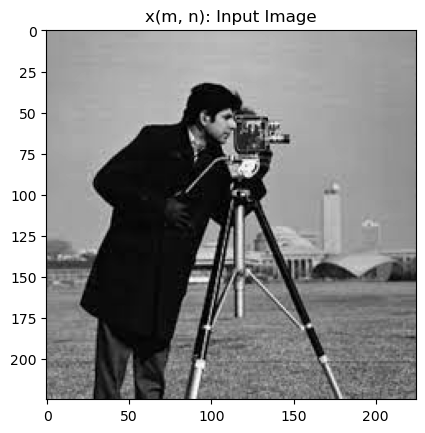

In [31]:
image = cv2.imread('cameraman.jpeg', cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap='gray')
plt.title('x(m, n): Input Image')
plt.show()

(Visual Purpose Only) Gaussian noise: The Gaussian noise that added to the image. This function shows tha amount of noise levels that varies with various sigma values centered at mean 0


Reference: https://stackoverflow.com/questions/17190649/how-to-obtain-a-gaussian-filter-in-python

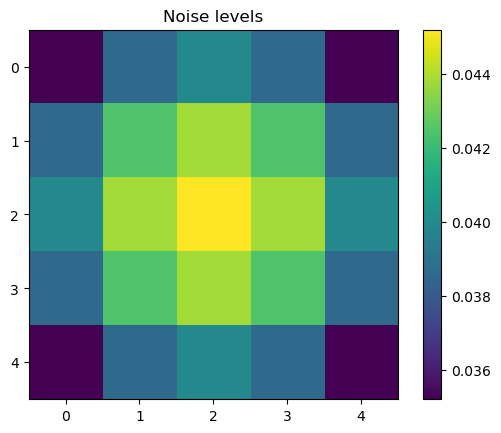

In [32]:
def gauss_kernal(size, sigma):
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()

noise = gauss_kernal(5, 4)
plt.imshow(noise)
plt.title('Noise levels')
plt.colorbar()
plt.show()

(Visual Purpose Only) Motion Blur: This functions generate a motion blur and its visual representation is shown

Reference: https://stackoverflow.com/questions/40305933/how-to-add-motion-blur-to-numpy-array

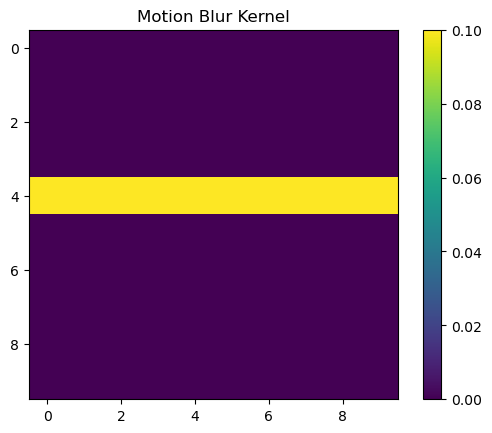

In [33]:
def motionblurKernel(size):
    motion_blur = np.zeros((size, size))
    motion_blur[int((size-1)/2), :] = np.ones(size)
    motion_blur = motion_blur / size
    return motion_blur

blur = motionblurKernel(10)
plt.imshow(blur)
plt.title('Motion Blur Kernel')
plt.colorbar()
plt.show()

To Test an algorithm using a known image blurred (Motion blur or Gaussian blur or Box) using a PSF of your choice, 
I have seperately created three functions which does motion blur, gaussian blur and box blur
Now, the blur function applied was motion blur but, I made it dynamic to choose other known blur functions.

The function accepts image inputs and return the blurred image and kernel

Reference: https://stackoverflow.com/questions/35192550/wiener-filter-for-image-deblur

In [34]:
def apply_motion_blur(image, size=3):
    
    img = np.copy(image)
    kernel = np.eye(size)/size       
    img = scipy.signal.convolve2d(img, kernel, mode='valid')
    img = np.uint8(img)
    
    return img, kernel

In [35]:
def apply_gaussian_blur(image, size=3):
    
    img = np.copy(image)
    kernel = gaussian(size, size/3).reshape(size, 1)
    kernel = np.dot(kernel, kernel.transpose())
    kernel /= np.sum(kernel)
    img = scipy.signal.convolve2d(img, kernel, mode='valid')
    img = np.uint8(img)
    
    return img, kernel

In [36]:
def apply_box(image, size=3):
    
    img = np.copy(image)
    kernel = np.ones((size, size))/(size*size)   
    img = scipy.signal.convolve2d(img, kernel, mode='valid')
    img = np.uint8(img)
    
    return img, kernel

Applying motion blur to an Image, Convolution(x(m,n), h(m,n)). Here h(m,n) is the Motion blur PSF

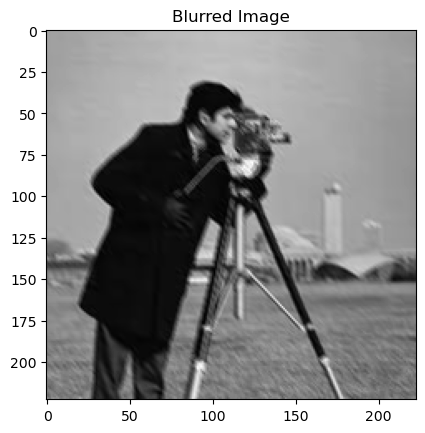

In [37]:
Blurred_image, kernel = apply_motion_blur(image)
plt.imshow(Blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.show()

Adding Gaussian noise to the blurred Image. Convolved{ (x(m,n), h(m,n)) + N }

This function accepts blurred image input and noise variance and returns the noisy image (noise added)

In [38]:
def add_gaussian_noise(img, variance):
    image = np.copy(img).astype(float)
    gaussian = np.random.normal(0, variance, np.shape(image))
    
    noisy_image = image + gaussian
    noisy_image = np.round(noisy_image)
    
    #Random values may exceed 0, 255: so keeping bounds
    noisy_image[np.where(image<0)] = 0
    noisy_image[np.where(image>255)] = 255
    
    noisy_image = np.uint8(noisy_image)
    
    return noisy_image

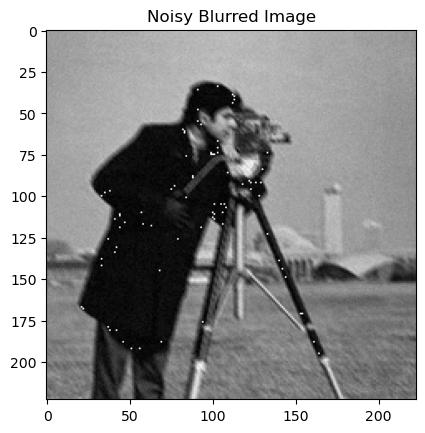

In [39]:
noisy_blurred_image = add_gaussian_noise(Blurred_image, 4)
plt.imshow(noisy_blurred_image, cmap='gray')
plt.title('Noisy Blurred Image')
plt.show()

The white dots appears here (above Noisy Blurred Image)  are due to the effect of noise

### Wiener filtering Part

This function accepts blurred noisy image as input and the applied kernel. returns the reconstructed image. Which is noise reduced.

Used the formula: G = H*/(|H|^2+1/K) where k is the SNR = Sxx/Snn. H is the dft2 of kernel function. Sxx is the PSD of input image and Snn is the PSD of noise. I have assumed things that, k is fixed as 0.2.

In [40]:
def filters(blurred_noisy_image, h, k=5):
    
    image = np.copy(blurred_noisy_image)
    
    h = np.pad(h, [(0, image.shape[0] - h.shape[0]), (0, image.shape[1] - h.shape[1])], 'constant')
    
    dft_image = np.fft.fft2(image)
    dft_h = np.fft.fft2(h)
    
    dft_h_conjugate = np.conj(dft_h)
    
    weiner_filter = dft_h_conjugate/((np.abs(dft_h)*np.abs(dft_h))+(1/k))
    
    dft_output_image = dft_image * weiner_filter
    output_image = np.fft.ifft2(dft_output_image)
    
    output_image = np.uint8(np.abs(output_image))
    
    return output_image

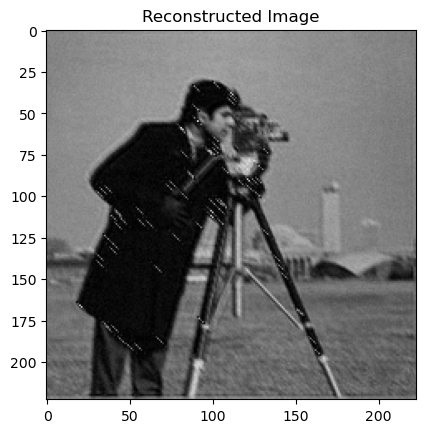

In [41]:
reconst_image = filters(noisy_blurred_image, kernel)
plt.imshow(reconst_image, cmap='gray')
plt.title('Reconstructed Image')
plt.show()

### Estimating SNR

This functions evaluates SNR, accepts input image and the known PSF. returns the SNR (k) which can be passed to the reconstructing filter.

The fuction evaluates the power spectral density of image and noise by finding their own Auto-correlation function and taking fourier transform of it.
Referring to http://faculty.jsd.claremont.edu/jmilton/Math_Lab_tool/Labs/Lab9.pdf notes, PSD of both output image and noise calculated accordingly. 

In class, wkt, Syy = |H|^2 + Snn where Syy is PSD of Blurred Noisy image. Snn can be estivated by guess of using noise variance technique (Variance of good pixel values are constant region).

By this, 
Sxx = ( Syy - Snn )/|H|^2 can be estimated.(Image should be N*N size) but, Instead of guessing for Snn, I used same gaussian noise for estimating. When the noise is unknown we can guess the noise variance instead of passing PSF.

Also SNR = Var of Image / Var of Noise

In [42]:
def determine_SNR(image, h):
    ACF_Image = scipy.signal.correlate2d(image, image)
    Syy = abs(np.fft.fft2(ACF_Image))
    
    h = np.pad(h, [(0, image.shape[0] - h.shape[0]), (0, image.shape[1] - h.shape[1])], 'constant')
    
    ACF_Noise = scipy.signal.correlate2d(h, h)
    Snn = abs(np.fft.fft2(ACF_Noise))
    
    h = np.pad(h, [(0, Syy.shape[0] - h.shape[0]), (0, Syy.shape[1] - h.shape[1])], 'constant')    
    dft_h = np.fft.fft2(h)
        
    Sxx = (Syy - Snn)/(abs(dft_h)**2)
    
    #Sn = np.linalg.norm(Snn)
    #Sx = np.linalg.norm(Sxx)
    
    Sx = np.mean(Sxx)
    Sn = np.mean(Snn)
    k = Sx/Sn
    print('SNR = ',k)
    print('1/k is ',1/k)
    return k

In [ ]:
k = determine_SNR(noisy_blurred_image, kernel)

Tried to reconstruct the image with the calculated very high SNR:

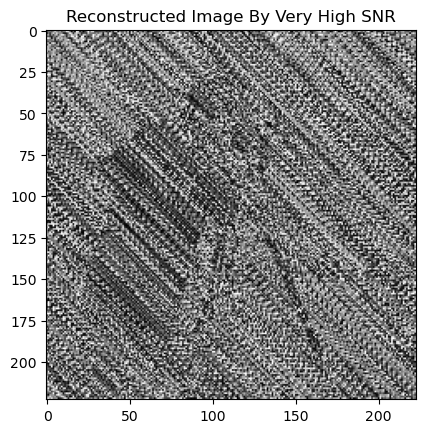

In [22]:
reconst_image = filters(noisy_blurred_image, kernel, k)
plt.imshow(reconst_image, cmap='gray')
plt.title('Reconstructed Image By Very High SNR')
plt.show()

### Estimating SNR by SNR = Var(Input Image)/Var(Noise)

In [24]:
def SNR_by_variance(image, h):
    
    h = np.pad(h, [(0, image.shape[0] - h.shape[0]), (0, image.shape[1] - h.shape[1])], 'constant')
    
    varianceMatrix = ndimage.generic_filter(image, np.var, size = 3)
    varX = np.mean(varianceMatrix)
    
    varianceNoise = ndimage.generic_filter(h, np.var, size = 3)
    varY = np.mean(varianceNoise)
    
    k = varX/varY
    print('SNR = ',k)
    print('1/k is ',1/k)
    return k

SNR =  10362959.633720933
1/k is  9.649752921414586e-08


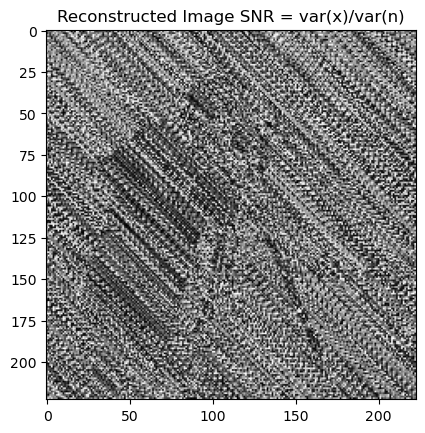

In [25]:
k = SNR_by_variance(noisy_blurred_image, kernel)
reconst_image = filters(noisy_blurred_image, kernel, k)
plt.imshow(reconst_image, cmap='gray')
plt.title('Reconstructed Image SNR = var(x)/var(n)')
plt.show()

### Calculating the Efficiency:

#### 1. PSNR (Peak Signal to Noise Ration)
PSNR = 20 log10{(L-1)/RMSE}, where L is the no of possible maximum possible intensity levels and
RMSE is the root mean squared error. The large value of PSNR is the good efficient filter

Reference: https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/

In [26]:
def PSNR(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [27]:
psnr = PSNR(noisy_blurred_image, reconst_image)
print('PSNR = ', psnr)

PSNR =  27.92834192030089


#### 2. Fixed Blur and Varying Noise

The algorithm which is written works very poorly when the noise level is increased. By fixing the PSF and increasing the noise, the reconstructed image resulted poorly and the k is set accordingly for improved results.

#### 3. Fixed Noise and Varying Blur

By fixing the noise, The algorithm works satisfactory as the noise level is constant

#### 4. Speed

Speed of the algorithm is satisfactory yet computing SNR alone exceeds 20s. (I did manual, Not tested using any metrics)